In [ ]:
#Peatland Classification Data Prep
#Written by Nicholas Pontone

In [ ]:
!pip install -q geemap

In [ ]:
!pip uninstall rasterio

In [2]:
#data manipulation / visualization
import pandas as pd
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

#Sk Learn
import sklearn
from sklearn.model_selection import train_test_split # for splitting data into train and test samples
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Misc Packages
import time
import os

import ee
import geemap

In [3]:
ee.Authenticate()

Enter verification code:  4/1AfgeXvu4YWmqylnTlw0QeYqVgHn-l4rt2fGycQXIZ4qGQLvaUV_5LWl4zD4



Successfully saved authorization token.


In [3]:
#Initialize Earth Engine
ee.Initialize()


In [4]:
#Palsar
SWAVE_HH = ee.Image('users/NicholasPontone/mosaic_palsar_SWAVE_HH')
SWAVE_HV = ee.Image('users/NicholasPontone/mosaic_palsar_SWAVE_HV')
SWAVE_HVHH = ee.Image('projects/peatland-insar/assets/mosaic_palsar_SWAVE_HVHH')
SWAVE_RFDI = ee.Image('projects/peatland-insar/assets/Mosaic_Palsar_RFDI')

#12-Day Coherence VV
spring_VV = ee.Image('projects/peatland-insar/assets/spring_vv_coh12_mosaic')
summer_VV = ee.Image('projects/peatland-insar/assets/summer_vv_coh12_mosaic')
fall_VV = ee.Image('projects/peatland-insar/assets/fall_vv_coh12_mosaic')

#Backscatter
spring_VV_amp = ee.Image('projects/ee-landsatpercentiles1/assets/Spring_VV_AMP')
fall_VV_amp = ee.Image('projects/ee-landsatpercentiles1/assets/Fall_VV_AMP')

#Landsat
landsatB1 = ee.Image('projects/peatland-insar/assets/LandsatB1Mosaic')
landsatB2 = ee.Image('projects/peatland-insar/assets/LandsatB2Mosaic')
landsatB3 = ee.Image('projects/peatland-insar/assets/LandsatB3Mosaic')
landsatB4 = ee.Image('users/NicholasPontone/LandsatB4Mosaic')
landsatB5 = ee.Image('projects/peatland-insar/assets/LandsatB5Mosaic')
landsatB7 = ee.Image('projects/peatland-insar/assets/LandsatB7Mosaic')

#Forest Structure
blackSpruce = ee.Image('users/NicholasPontone/BlackSpruce_tif')
canopyHeight = ee.Image('users/NicholasPontone/height_tif')
canopyClosure = ee.Image('users/NicholasPontone/closure_tif')

#Topographic
slope = ee.Image("users/koreenmillard/larch2/slope")
slope42309 = ee.Image("users/koreenmillard/larch2/slope42309")
elevation = ee.Image("users/koreenmillard/larch2/elevation")

#Bioclimatic
bio2 = ee.Image("users/koreenmillard/larch2/BIO2")
bio4 = ee.Image("users/koreenmillard/larch2/BIO4")

#Misc Layers
ecozone = ee.Image("users/koreenmillard/larch2/ecozone")

#Percentiles
P10 = ee.Image("projects/ee-nicholaspontone/assets/WetnessPercentiles")
P40 = ee.Image("projects/ee-landsatpercentiles2/assets/WetnessP40")
P80 = ee.Image("projects/ee-landsatpercentiles1/assets/WetnessP80")
P90 = ee.Image("projects/ee-nicholaspontone/assets/WetnessP90")

#ALOS DSM
ADSM = ee.Image("projects/ee-landsatpercentiles2/assets/ALOSDSM")
ASlope = ee.Image("projects/ee-landsatpercentiles2/assets/ALOSSlope")


#Haromic NDVI Landsat
harmonic = ee.Image("projects/ee-harmonic-landsat/assets/HarmonicLandsatNDVI")

#Permafrost Prob
Permafrostprob = ee.Image("projects/ee-landsatpercentiles2/assets/PermafrostProbability")
Permafrostprob = ee.Image("projects/ee-harmoniclandsat2/assets/PermafrostPolygons")

In [24]:
#Vector Layers
pointData = ee.FeatureCollection("projects/ee-nicholaspontone/assets/TrainingData20220726_WetlandTypes_DanDucks");

#polygon = ee.FeatureCollection("users/NicholasPontone/PeatlandClassification/OntarioTiles")
polygon = ee.FeatureCollection("projects/ee-nicholaspontone/assets/QuebecTiles20220729")
#polygon = ee.FeatureCollection("users/koreenmillard/fishnet150x150_peatextent_selected")
#polygon = ee.FeatureCollection("users/NicholasPontone/WoodBuffaloTiles")
#polygon = ee.FeatureCollection("projects/ee-nicholaspontone/assets/FortSimpsonTiles")
#polygon = ee.FeatureCollection("projects/ee-nicholaspontone/assets/Yas_Tiles")
#Spatial Autocorrelation

waterpoints = ee.FeatureCollection("projects/ee-nicholaspontone/assets/GSW95Points20220906")

AutoC500m = ee.FeatureCollection("projects/ee-landsatpercentiles1/assets/AutoCPoints1000m")

AutoC1000m = ee.FeatureCollection("projects/ee-landsatpercentiles1/assets/AutoCPoints1000m")

In [6]:
#Project data and resample to 30m spatial resolution
proj = ee.Projection('EPSG:3857')

#Palsar
SWAVE_HH = SWAVE_HH.reproject(proj, None, 30)
SWAVE_HV = SWAVE_HV.reproject(proj, None, 30)
SWAVE_HVHH = SWAVE_HVHH.reproject(proj, None, 30)
SWAVE_RFDI = SWAVE_RFDI.reproject(proj, None, 30)

#Sentinel1 Coherence
spring_VV = spring_VV.reproject(proj, None, 30)
summer_VV = summer_VV.reproject(proj, None, 30)
fall_VV = fall_VV.reproject(proj, None, 30)

#S1 backscatter

spring_VV_amp = spring_VV_amp.reproject(proj, None, 30)
fall_VV_amp = fall_VV_amp.reproject(proj, None, 30)

#Landsat
landsatB1 = landsatB1.reproject(proj, None, 30)
landsatB2 = landsatB2.reproject(proj, None, 30)
landsatB3 = landsatB3.reproject(proj, None, 30)
landsatB4 = landsatB4.reproject(proj, None, 30)
landsatB5 = landsatB5.reproject(proj, None, 30)
landsatB7 = landsatB7.reproject(proj, None, 30)

#Forest Structure
blackSpruce = blackSpruce.reproject(proj, None, 30)
canopyHeight = canopyHeight.reproject(proj, None, 30)
canopyClosure = canopyClosure.reproject(proj, None, 30)

#Terrain
slope = slope.reproject(proj, None, 30)
slope42309 = slope42309.reproject(proj, None, 30)
elevation = elevation.reproject(proj, None, 30)

#Bioclimatic
bio2 = bio2.reproject(proj, None, 30)
bio4 = bio4.reproject(proj, None, 30)

#Misc Layers
ecozone = ecozone.reproject(proj, None, 30)

#Percentiles
P10 = P10.reproject(proj, None, 30)
P40 = P40.reproject(proj, None, 30)
P80 = P80.reproject(proj, None, 30)
P90 = P90.reproject(proj, None, 30)


#ALOS
ADSM = ADSM.reproject(proj, None, 30)
ASlope = ASlope.reproject(proj, None, 30)


#Haromic NDVI Landsat
harmonic = harmonic.reproject(proj, None, 30)

#Permafrost Probability
Permafrostprob = Permafrostprob.reproject(proj, None, 30)

In [7]:
Landsat = landsatB1.addBands(landsatB2).addBands(landsatB3).addBands(landsatB4).addBands(landsatB5).addBands(landsatB7)
Landsat2 = Landsat.rename('B1','B2','B3','B4','B5','B7')
Landsat2_Bands = Landsat2.bandNames()
Landsat2_Bands.getInfo()

['B1', 'B2', 'B3', 'B4', 'B5', 'B7']

In [8]:
image = ee.Image(1)

#Functions

def addSATVI(image):
    calcSATVI = image.expression('(((B5-B3)/(B5+B3+0.5))*(1+0.5))-(B7/2)', {
        'B3': image.select ('B3').float(),
        'B5': image.select ('B5').float(),
        'B7': image.select ('B7').float(),
        }).rename('SATVI')
    return image.addBands(calcSATVI)

def addMSAVI2(image) :
    calcMSAVI2 = image.expression(
        '((2.0*(B4 +1)) - sqrt(((2.0*(B4+1))*(2.0*(B4+1))) - (8.0 * (B4 - B3))))/2.0', {
        'B4': image.select ('B4').float(),
        'B3': image.select ('B3').float(),
        }).rename('MSAVI2');
    return image.addBands(calcMSAVI2)

def addEVI(image):
    calcEVI = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': image.select('B4'),
        'RED': image.select('B3'),
        'BLUE': image.select('B1'),
        }).rename('EVI');
    return image.addBands(calcEVI);

def addSAVI(image):
    calcSAVI = image.expression(
        '((B5 - B4) / (B5 + B4 + 0.5)) * (1.0 + 0.5)', {
        'B5': image.select ('B5').float(),
        'B4': image.select ('B4').float(),
        }).rename('SAVI');
    return image.addBands(calcSAVI);

In [9]:
Landsat3 = ee.ImageCollection(Landsat2)\
                  .map(addEVI) \
                  .map(addSAVI) \
                  .map(addSATVI) \
                  .map(addMSAVI2) \
                  .mosaic()

In [10]:
Landsat_Bands = Landsat3.bandNames()
Landsat_Bands.getInfo()

['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'EVI', 'SAVI', 'SATVI', 'MSAVI2']

In [11]:
stacked_composite = SWAVE_HH.addBands(SWAVE_HV)\
.addBands(SWAVE_HVHH).addBands(SWAVE_RFDI).addBands(spring_VV).addBands(summer_VV)\
.addBands(fall_VV).addBands(Landsat3).addBands(blackSpruce).addBands(canopyHeight)\
.addBands(canopyClosure).addBands(slope).addBands(slope42309)\
.addBands(elevation).addBands(bio2).addBands(bio4).addBands(ecozone)\
.addBands(P10).addBands(P40).addBands(P80).addBands(P90).addBands(harmonic)\
.addBands(spring_VV_amp).addBands(fall_VV_amp).addBands(Permafrostprob)

In [12]:
Names = ["SWAVE_HH","SWAVE_HV","SWAVE_HVHH","SWAVE_RFDI","spring_VV","summer_VV","fall_VV",'B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'EVI', 'SAVI', 'SATVI', 'MSAVI2'
         ,'blackSpruce','canopyHeight','canopyClosure','slope','slope42309','elevation','bio2','bio4','ecozone','P10','P40','P80','P90','NDVIPhase','NDVIAmp','NDVIMean','spring_VV_amp','fall_VV_amp','PF_prob']

In [13]:
band_names = stacked_composite.bandNames()
stacked_composite2 = stacked_composite.select(band_names).rename(Names)

In [14]:
stacked_composite2.bandNames().getInfo()

['SWAVE_HH',
 'SWAVE_HV',
 'SWAVE_HVHH',
 'SWAVE_RFDI',
 'spring_VV',
 'summer_VV',
 'fall_VV',
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B7',
 'EVI',
 'SAVI',
 'SATVI',
 'MSAVI2',
 'blackSpruce',
 'canopyHeight',
 'canopyClosure',
 'slope',
 'slope42309',
 'elevation',
 'bio2',
 'bio4',
 'ecozone',
 'P10',
 'P40',
 'P80',
 'P90',
 'NDVIPhase',
 'NDVIAmp',
 'NDVIMean',
 'spring_VV_amp',
 'fall_VV_amp',
 'PF_prob']

In [15]:
proj = ee.Projection('EPSG:3857');

#Clip images to AOI
clippedAndre = stacked_composite2.clipToCollection(polygon);
tempList = clippedAndre.bandNames()
print('Band names:', tempList.getInfo())

Band names: ['SWAVE_HH', 'SWAVE_HV', 'SWAVE_HVHH', 'SWAVE_RFDI', 'spring_VV', 'summer_VV', 'fall_VV', 'B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'EVI', 'SAVI', 'SATVI', 'MSAVI2', 'blackSpruce', 'canopyHeight', 'canopyClosure', 'slope', 'slope42309', 'elevation', 'bio2', 'bio4', 'ecozone', 'P10', 'P40', 'P80', 'P90', 'NDVIPhase', 'NDVIAmp', 'NDVIMean', 'spring_VV_amp', 'fall_VV_amp', 'PF_prob']


In [19]:
# Extract pixel values to training data points
training = clippedAndre.sampleRegions(
  collection = waterpoints,
  properties = ['PeatlandTy'],
  geometries = True,
  scale = 30
)

In [20]:
#Execute task and export training data to cloud storage
task = geemap.ee.batch.Export.table.toCloudStorage(
    collection = training,
    description = 'trainingData_LS5',
    fileNamePrefix = 'TrainingData_WaterPoints_20230105',
    bucket = 'nick-pontone-bucket',
    fileFormat = 'CSV'
)

#'TrainingDataDanDucks_33BandsJuly',  #Change to fileNameChange

task.start()

In [ ]:
#YOU ONLY NEED TO RUN THIS CELL IF YOU DO NOT HAVE THE TILES, IF YOU HAVE THE TILES.
fc = ee.FeatureCollection(polygon)
#print(fc)

emptyList = []

featlist = fc.getInfo()["features"];
for f in range(len(featlist)):
    feat = ee.Feature(featlist[f])
    dis = feat.get("TileID")
    disS = dis.getInfo()
    
    print("Tile = ", disS, "but f = ", f)
    nameA = "Quebec"
    #Sets up the export rules
    task = geemap.ee.batch.Export.image.toCloudStorage(
         image = clippedAndre.toFloat(),
         description = nameA + str(disS),
         bucket = 'nick-pontone-bucket',
         fileNamePrefix = 'PeatlandClassification/QuebecTiles' + '/' +  nameA + str(disS),
         region = feat.geometry().bounds(),
         scale = 30
        )
    
        #Starts the task
    task.start()


In [3]:
df1 = pd.read_csv("C:\\Users\\Nicho\\Documents\\Masters_Analyis\TrainingData\\Permafrost\\TrainingData_AllPoints_20221104(1).csv")
df2 = pd.read_csv("C:\\Users\\Nicho\\Documents\\Masters_Analyis\TrainingData\\Permafrost\\TrainingData_WaterPoints_20221104(1).csv")

concatDF = pd.concat([df1,df2])

In [35]:
concatDF.to_csv("C:\\Users\\Nicho\\Documents\\Masters_Analyis\TrainingData\\Permafrost\\TrainingData_PFTest_20221107.csv")

NameError: name 'concatDF' is not defined

In [21]:
#Read in training data
#trainingDataXD = pd.read_csv('C:\\Users\\Nicho\\Documents\\Masters_Analyis\TrainingData\\Permafrost\\TrainingData_PFTest_20221107.csv')
trainingDataXD = pd.read_csv('C:\\Users\\Nicho\\Documents\\Masters_Analyis\TrainingData\\Permafrost\\TrainingData_AllPoints_20230105.csv')

#Drop Index and .GEO columns
trainingDataXD.drop(labels='system:index', axis=1, inplace=True)
trainingDataXD.drop(labels='.geo', axis=1, inplace=True)
#trainingDataXD.drop(labels= ['x','y','field_1','Unnamed: 0'], axis = 1, inplace=True)
trainingDataXD = trainingDataXD.dropna()

In [ ]:
ColumnTitles = ['SWAVE_HH', 'SWAVE_HV', 'SWAVE_HVHH', 'SWAVE_RFDI', 'spring_VV', 'summer_VV', 'fall_VV', 'B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'EVI', 'SAVI', 'SATVI', 'MSAVI2', 'blackSpruce', 'canopyHeight', 'canopyClosure', 'slope', 'slope42309', 'elevation', 'bio2', 'bio4', 'ecozone', 'P10', 'P40', 'P80', 'P90', 'NDVIPhase', 'NDVIAmp', 'NDVIMean','PeatlandTy','spring_VV_amp','fall_VV_amp','PFP_prob']
trainingDataXD = trainingDataXD.reindex(columns = ColumnTitles)

In [ ]:
trainingDataXD = trainingDataXD.rename(columns = {'B1': 'Coastal Aerosal','B2': 'Blue','B3': 'Green','B4':'Red','B5':'NIR','B7':'SWIR'})

In [77]:
#Dropping bands

####Stage 1####
#trainingDataXD.drop(labels = ['elevation','slope','slope42309','bio2', 'bio4', 'ecozone','blackSpruce','fall_VV', 'spring_VV', 'summer_VV','spring_VV_amp','fall_VV_amp'], axis = 1, inplace = True)

####Stage 2 and 3####
trainingDataXD.drop(labels = ['elevation','slope','slope42309','bio2', 'bio4', 'ecozone','blackSpruce'], axis = 1, inplace = True)

In [78]:
trainingDataXD.columns

Index(['SWAVE_HH', 'SWAVE_HV', 'SWAVE_HVHH', 'SWAVE_RFDI', 'spring_VV',
       'summer_VV', 'fall_VV', 'Coastal Aerosal', 'Blue', 'Green', 'Red',
       'NIR', 'SWIR', 'EVI', 'SAVI', 'SATVI', 'MSAVI2', 'canopyHeight',
       'canopyClosure', 'P10', 'P40', 'P80', 'P90', 'NDVIPhase', 'NDVIAmp',
       'NDVIMean', 'PeatlandTy', 'spring_VV_amp', 'fall_VV_amp', 'PFP_prob'],
      dtype='object')

In [7]:
##Stage 1 feature selection
trainingDataXD = trainingDataXD[['SWAVE_HH', 'SWAVE_HV', 'Red', 'NIR', 'SWIR', 'SATVI', 'MSAVI2', 'P10',
       'NDVIPhase', 'NDVIAmp','PeatlandTy']]

##Stage 2 feature selection
#trainingDataXD = trainingDataXD[['SWAVE_HH', 'SWAVE_HV', 'SWAVE_HVHH', 'spring_VV', 'summer_VV',
#       'fall_VV', 'Red', 'MSAVI2', 'P80', 'P90', 'NDVIPhase', 'NDVIAmp',
#       'NDVIMean','PeatlandTy']]

In [79]:
#Create class dictionary
Class_Dictionary = {'FB':0, 'FP':1, 'FPFC':2, 'FR':3, 'FUL':4, 'FUNK':5, 'OB':6,'OP':7, 'OPFC':8, 'OR':9, 'OUL':10, 'OUNK':11,'TB':12, 'TP':13, 'TPFC':14, 'TR':15, 'TUL':16, 'TUNK':17, 'MAR':18, 'SWP':19,'WA':20}

#Assigning classes numerical values based on dictionary
trainingDataXD['PeatlandTy'] = trainingDataXD['PeatlandTy'].map(Class_Dictionary)

In [80]:
#Replace unknown peat with -1 to mark it as unlabelled
trainingDataXD['PeatlandTy'] = trainingDataXD['PeatlandTy'].replace([5,11,17],-1)


#Reclass so that wetlands = 1 and upland =2 and water =3. Stage 1
#trainingDataXD['PeatlandTy'] = trainingDataXD['PeatlandTy'].replace([-1,0,1,2,3,6,7,8,9,12,13,14,15,18,19],1)
#trainingDataXD['PeatlandTy'] = trainingDataXD['PeatlandTy'].replace([4,10,16],2)
#trainingDataXD['PeatlandTy'] = trainingDataXD['PeatlandTy'].replace([20],3)


#Reclass so that peatlands = 1 and mineral wetlands = 2.  Stage 2
#trainingDataXD['PeatlandTy'] = trainingDataXD['PeatlandTy'].replace([-1,0,1,2,3,6,7,8,9,12,13,14,15],1)
#trainingDataXD['PeatlandTy'] = trainingDataXD['PeatlandTy'].replace([18,19],2)
#trainingDataXD = trainingDataXD.query("PeatlandTy != [10,16,4,20]")


#Reclass so that Bog = 1, Rich Fen = 2, Poor Fen =3, permafrost = 4. Stage 3
trainingDataXD = trainingDataXD[trainingDataXD['PeatlandTy'].isin([0,12,6,3,9,15,1,7,13,2,8,14,-1])] 
trainingDataXD['PeatlandTy'] = trainingDataXD['PeatlandTy'].replace([0,12,6,3,9,15,1,7,13,2,8,14],[1,1,1,2,2,2,3,3,3,4,4,4])
trainingDataXD = trainingDataXD.query("PeatlandTy != [10,16,20,-1]")





In [81]:
trainingDataXD = trainingDataXD.dropna()

In [82]:
trainingDataXD['PeatlandTy'].value_counts()

4.0    479
3.0    291
2.0    272
1.0    233
Name: PeatlandTy, dtype: int64

In [12]:
Unlabelled = trainingDataXD[trainingDataXD['PeatlandTy'] == -1]
trainingDataXD = trainingDataXD[trainingDataXD['PeatlandTy'] != -1]

In [83]:
labels = trainingDataXD['PeatlandTy']
#labels = pd.Series(labels, name = "Names")
#labels = labels.to_frame()

#labels["id"] = labels.groupby(['Names']).ngroup()
#labels = labels["id"]
#labels = labels.squeeze()
trainingDataXD = trainingDataXD.drop(columns = ['PeatlandTy'])

In [258]:
Unlabelled_Labels = Unlabelled['PeatlandTy']
Unlabelled_Predictors = Unlabelled.drop(columns = ['PeatlandTy'])

In [84]:
x_train, x_test, y_train, y_test = train_test_split(trainingDataXD, labels, test_size=0.30,random_state=6)

In [18]:
x_train = pd.DataFrame(x_train)
x_train = pd.concat([x_train, Unlabelled_Predictors])
x_train = x_train.values[0:len(x_train)]

y_train = pd.concat([y_train, Unlabelled_Labels])

NameError: name 'Unlabelled_Predictors' is not defined

In [85]:
#Define Classifier
RF = RandomForestClassifier(n_estimators = 1000, random_state=157, n_jobs=-1)

In [86]:
#Train RF
RF.fit(x_train,y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=157)

In [87]:
Results = RF.predict(x_test)

In [88]:
print('---------- Random Forest - Evaluation on Test Data ----------')
accuracy_score_ST = RF.score(x_test.values, y_test)
print('Accuracy Score: ', accuracy_score_ST)
# Look at classification report to evaluate the model
print(classification_report(y_test, RF.predict(x_test.values),zero_division=0))

confusion = pd.crosstab(y_test, Results, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(confusion)

---------- Random Forest - Evaluation on Test Data ----------
Accuracy Score:  0.7310704960835509


C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

         1.0       0.73      0.48      0.58        66
         2.0       0.67      0.72      0.69        82
         3.0       0.59      0.66      0.62        91
         4.0       0.86      0.90      0.88       144

    accuracy                           0.73       383
   macro avg       0.71      0.69      0.69       383
weighted avg       0.73      0.73      0.73       383

Predicted  1.0  2.0  3.0  4.0  All
Actual                            
1.0         32    2   23    9   66
2.0          2   59   15    6   82
3.0          7   18   60    6   91
4.0          3    9    3  129  144
All         44   88  101  150  383


In [34]:
#Feature selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest, mutual_info_regression

In [35]:
#SelectKBest
selector = SelectKBest(mutual_info_regression)
selector.fit(x_test, y_test)
x_test.columns[selector.get_support()]

Index(['spring_VV', 'summer_VV', 'canopyHeight', 'canopyClosure', 'P40', 'P80',
       'P90', 'NDVIPhase', 'NDVIAmp', 'NDVIMean'],
      dtype='object')

In [36]:
#RFE
rfe = RFE(estimator = RF)
_ = rfe.fit(x_train,y_train)



In [37]:
x_train.columns[rfe.support_]

Index(['SWAVE_HH', 'SWAVE_HV', 'SWAVE_HVHH', 'spring_VV', 'summer_VV',
       'fall_VV', 'Red', 'MSAVI2', 'P80', 'P90', 'NDVIPhase', 'NDVIAmp',
       'NDVIMean'],
      dtype='object')

In [650]:
df2 = gpd.read_file('C:\\Users\\Nicho\\Documents\\Masters_Analyis\\TrainingData\\TrainingData20220908_DanDucksV6_CVFolds.csv')

C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [624]:
ColumnTitles = ['SWAVE_HH', 'SWAVE_HV', 'SWAVE_HVHH', 'SWAVE_RFDI', 'spring_VV', 'summer_VV', 'fall_VV', 'B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'EVI', 'SAVI', 'SATVI', 'MSAVI2', 'blackSpruce', 'canopyHeight', 'canopyClosure', 'slope', 'slope42309', 'elevation', 'bio2', 'bio4', 'ecozone', 'P10', 'P40', 'P80', 'P90', 'NDVIPhase', 'NDVIAmp', 'NDVIMean','PeatlandTy','Folds']
df = df.reindex(columns = ColumnTitles)

In [625]:
df.columns

Index(['SWAVE_HH', 'SWAVE_HV', 'SWAVE_HVHH', 'SWAVE_RFDI', 'spring_VV',
       'summer_VV', 'fall_VV', 'B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'EVI',
       'SAVI', 'SATVI', 'MSAVI2', 'blackSpruce', 'canopyHeight',
       'canopyClosure', 'slope', 'slope42309', 'elevation', 'bio2', 'bio4',
       'ecozone', 'P10', 'P40', 'P80', 'P90', 'NDVIPhase', 'NDVIAmp',
       'NDVIMean', 'PeatlandTy', 'Folds'],
      dtype='object')

In [603]:
df['PeatlandTy']

0         B
1         B
2         B
3         B
4         B
         ..
16514    WA
16515    WA
16516    WA
16517    WA
16518    WA
Name: PeatlandTy, Length: 16519, dtype: object

In [626]:
#Create class dictionary
#Assigning classes numerical values based on dictionary
df['PeatlandTy'] = df['PeatlandTy'].map(Class_Dictionary)

In [627]:
df['PeatlandTy'] = df['PeatlandTy'].replace([5,11,17],-1)


#df = df[df['PeatlandTy'].isin([0,12,6,3,9,15,1,7,13,2,8,14,-1])] 
#df['PeatlandTy'] = df['PeatlandTy'].replace([0,12,6,3,9,15,1,7,13,2,8,14],[1,1,1,2,2,2,3,3,3,4,4,4])
#df = df.query("PeatlandTy != [10,16,20,-1]")


#Reclass so that peatlands = 1 and mineral wetlands = 2.  Stage 2
df['PeatlandTy'] = df['PeatlandTy'].replace([-1,0,1,2,3,6,7,8,9,12,13,14,15],1)
df['PeatlandTy'] = df['PeatlandTy'].replace([18,19],2)
df = df.query("PeatlandTy != [10,16,4,20]")

#df['PeatlandTy'] = df['PeatlandTy'].replace([-1,0,1,2,3,6,7,8,9,12,13,14,15,18,19],1)
#df['PeatlandTy'] = df['PeatlandTy'].replace([4,10,16],2)
#df['PeatlandTy'] = df['PeatlandTy'].replace([20],3)



df = df.dropna()

In [628]:
df['PeatlandTy'].value_counts()

1.0    3491
2.0     994
Name: PeatlandTy, dtype: int64

In [629]:

X = df.drop(columns = ['PeatlandTy','elevation','slope','slope42309','bio2', 'bio4', 'ecozone','blackSpruce'])
y = df['PeatlandTy']

In [630]:
folds = df['Folds']

In [611]:
X.columns

Index(['SWAVE_HH', 'SWAVE_HV', 'SWAVE_HVHH', 'SWAVE_RFDI', 'B1', 'B2', 'B3',
       'B4', 'B5', 'B7', 'EVI', 'SAVI', 'SATVI', 'MSAVI2', 'canopyHeight',
       'canopyClosure', 'P10', 'P40', 'P80', 'P90', 'NDVIPhase', 'NDVIAmp',
       'NDVIMean', 'Folds'],
      dtype='object')

In [523]:
folds.values

array([10, 10, 10, ...,  7,  7,  2], dtype=int64)

In [589]:
skcv = spacv.SKCV(n_splits=4, buffer_radius=100).split(XYs)

In [577]:
from sklearn.model_selection import GroupShuffleSplit

In [633]:
cv = GroupShuffleSplit(n_splits = 10, test_size = 0.3, random_state = 6).split(X,y,folds)

In [613]:
scores = cross_val_score(RF,
                         X,
                         y,
                         cv =10)

In [634]:
scores = cross_val_score(RF,       # Model 
                X,         # Features
                y,         # Labels
                cv =cv ) # Fold indices

In [635]:
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

0.930 accuracy with a standard deviation of 0.014


In [318]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

In [323]:
loo = LeaveOneOut()
loo.get_n_splits(x_train)

892

In [343]:
y_true, y_pred = list(), list()

In [351]:
X = [1,2,3,4]
loo = LeaveOneOut()
for train, test in loo.split(X):
    print

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


In [321]:
kf = KFold()

In [244]:
Results = STM.predict(x_test)

C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelfTrainingClassifier was fitted without feature names
  warnings.warn(


In [673]:
import seaborne as sns

ModuleNotFoundError: No module named 'seaborne'

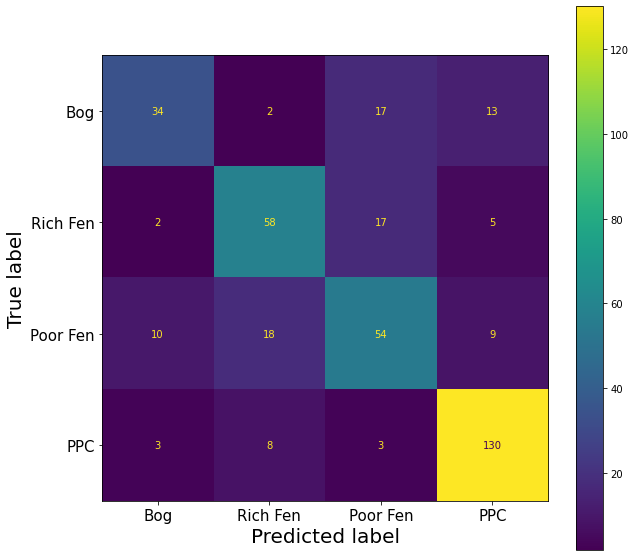

In [21]:
cm = confusion_matrix(y_test, Results, labels=RF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Bog','Rich Fen','Poor Fen', 'PPC'])
ax = plt.subplot()
ax.tick_params(axis='both',  labelsize = 15)
ax.set_ylabel("True Label", fontsize = 20)
ax.set_xlabel("Predicted Label", fontsize = 20)
disp.plot(ax = ax)


In [89]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    RF, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index = list(trainingDataXD.columns))

Elapsed time to compute the importances: 31.036 seconds


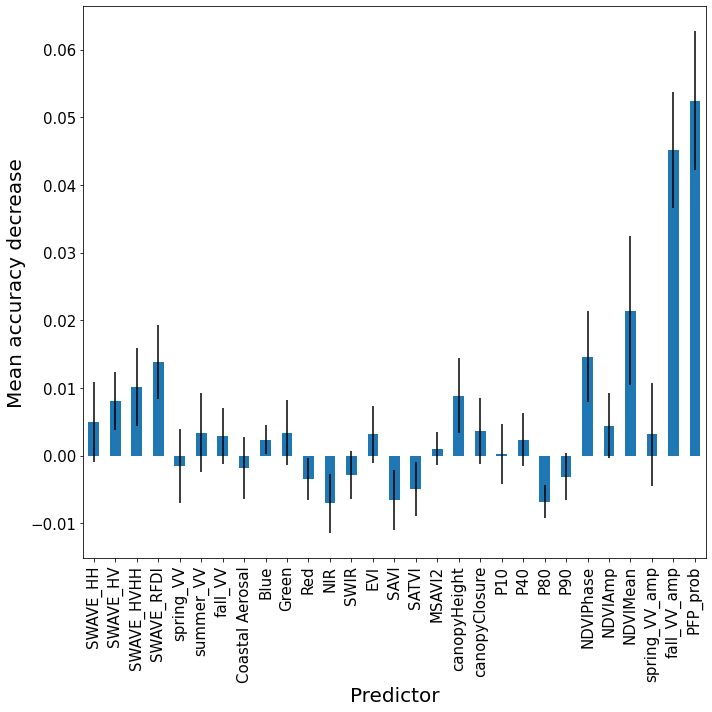

In [90]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_ylabel("Mean accuracy decrease", fontsize = 20)
ax.tick_params(axis='both',  labelsize = 15)
ax.set_xlabel("Predictor", fontsize = 20)
fig.tight_layout()
plt.show()

In [64]:
# Get the tif image and convert it to a raster -  we will use the rasterio package here which requires some reshaping of the image
img = rasterio.open('E:\\Thesis\\Permafrost\\Tiles\\PermafrostTest\\PermaFrostTestTileID2853.tif')

# Get the transform and crs from the image to use when exporting the image
transform = img.transform
crs = img.crs

# Read the actual image info and reshape 
temp_info = reshape_as_image(img.read())

new_shape = (temp_info.shape[0] * temp_info.shape[1], temp_info.shape[2])
temp_as_array = temp_info[:, :, :].reshape(new_shape)

#Impute missing values to 9999 (It's water that will be masked, so it doesn't matter)
imp_mean = SimpleImputer(missing_values = np.nan, strategy ='constant', fill_value = 9999)
imp_mean.fit(temp_as_array)

temp_as_array = imp_mean.transform(temp_as_array)

In [65]:
desc = img.descriptions
print('Raster description: {desc}\n'.format(desc=desc))
names = list(desc)


Raster description: ('SWAVE_HH', 'SWAVE_HV', 'SWAVE_HVHH', 'SWAVE_RFDI', 'spring_VV', 'summer_VV', 'fall_VV', 'B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'EVI', 'SAVI', 'SATVI', 'MSAVI2', 'blackSpruce', 'canopyHeight', 'canopyClosure', 'slope', 'slope42309', 'elevation', 'bio2', 'bio4', 'ecozone', 'P10', 'P40', 'P80', 'P90', 'NDVIPhase', 'NDVIAmp', 'NDVIMean', 'spring_VV_amp', 'fall_VV_amp', 'PF_prob')



In [68]:
#Drop bands for testing. Make sure they match the bands you dropped from the training data.
temp_as_array = pd.DataFrame(temp_as_array)
temp_as_array.columns = names

#Stage 1
#temp_as_array = temp_as_array[['SWAVE_HH', 'SWAVE_HV', 'B4', 'B5', 'B7', 'SATVI', 'MSAVI2', 'P10',
#       'NDVIPhase', 'NDVIAmp']]


#Stage 2
temp_as_array = temp_as_array[['SWAVE_HH', 'SWAVE_HV', 'SWAVE_HVHH', 'spring_VV', 'summer_VV',
       'fall_VV', 'B4', 'MSAVI2', 'P80', 'P90', 'NDVIPhase', 'NDVIAmp',
       'NDVIMean']]

temp_as_array = temp_as_array.to_numpy()

In [69]:
# Use the random forest classifier to classify the image
# and measure the time it takes
startTime = time.time()

classified_image = RF.predict(temp_as_array)
print('Classification finished in ' + str(time.time() - startTime) + ' seconds\n')

# Reshape the classified image back into a 2D image (with only a single band)
classified_image_new = classified_image.reshape(temp_info[:, :, 1].shape)

# Set the data type of the image
classified_image_new = classified_image_new.astype('int32')

classified_image_new

C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 62.37815880775452 seconds



array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 2, ..., 1, 1, 1],
       [2, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [70]:
import matplotlib

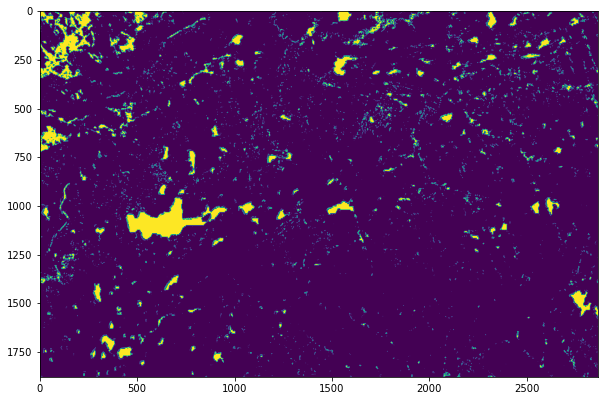

In [71]:
matplotlib.pyplot.imshow(classified_image_new)

In [68]:
with rasterio.open(
            "Variableslectiontest.tif",
              'w',
            driver = 'GTiff',
            height = classified_image_new.shape[0],
            width = classified_image_new.shape[1],
            count = 1,
            dtype = classified_image_new.dtype,
            crs = crs,
            transform = transform,
        ) as dst:
            dst.write(classified_image_new, 1)
            dst.close()

In [ ]:
TileDF = pd.read_csv('E:\\Thesis\\QuebecTest\\MansuyTiles.csv')
TileList = TileDF['TileID'].tolist()
TileList = [x + ".tif" for x in TileList]


In [ ]:
TestString = os.listdir("C:\\Users\\Lion\\NickPontone\\QuebecTileFolder")[0]

In [ ]:
TestString.partition('y')[2]

In [74]:
#Classify many tiles

directory = "E:\\Thesis\\SMAPTiles\\Version2\\Berms_Permafrost"
counter = 1


for filename in os.listdir(directory):
    
    if counter == 1:
        desc = img.descriptions
        names = list(desc)

        
        
    x = os.path.join(directory, filename)

    # Get the tif image and convert it to a raster -  we will use the rasterio package here which requires some reshaping of the image
    img = rasterio.open(x)

    # Get the transform and crs from the image to use when exporting the image
    transform = img.transform 
    crs = img.crs

    # Read the actual image info and reshape 
    temp_info = reshape_as_image(img.read())

    new_shape = (temp_info.shape[0] * temp_info.shape[1], temp_info.shape[2])
    temp_as_array = temp_info[:, :, :].reshape(new_shape)

    #Impute missing values to 9999 (It's water that will be masked, so it doesn't matter)
    imp_mean = SimpleImputer(missing_values = np.nan, strategy ='constant', fill_value = 9999)
    imp_mean.fit(temp_as_array)

    temp_as_array = imp_mean.transform(temp_as_array)
    temp_as_array = pd.DataFrame(temp_as_array)
    #temp_as_array = temp_as_array.drop(columns=[4,5,6,17,20,21,22,23,24,25]) #Stage 1
    #temp_as_array = temp_as_array.drop(columns=[17,20,21,22,23,24,25,33,34])   #Stage 2/3
    temp_as_array.columns = names
    #temp_as_array = temp_as_array[['SWAVE_HH', 'SWAVE_HV', 'B4', 'B5', 'B7', 'SATVI', 'MSAVI2', 'P10',
    #       'NDVIPhase', 'NDVIAmp']]
    temp_as_array = temp_as_array[['SWAVE_HH', 'SWAVE_HV', 'SWAVE_HVHH', 'spring_VV', 'summer_VV',
       'fall_VV', 'B4', 'MSAVI2', 'P80', 'P90', 'NDVIPhase', 'NDVIAmp',
       'NDVIMean']]
    temp_as_array = temp_as_array.to_numpy()

    # Use the random forest classifier to classify the image
    # and measure the time it takes
    startTime = time.time()

    classified_image = RF.predict(temp_as_array)
    print('Classification finished in ' + str(time.time() - startTime) + ' seconds\n')

    # Reshape the classified image back into a 2D image (with only a single band)
    classified_image_new = classified_image.reshape(temp_info[:, :, 1].shape)

    # Set the data type of the image
    classified_image_new = classified_image_new.astype('int32')


    #Sets up the export rules
    exportName = "E:\\Thesis\\SMAPTiles\\Version2\\Stage2Reducedvariables\\" + 'BermsPFS3' + str(counter) + 'Tile.tif'  
    counter += 1


    # Export the image using rasterio
    with rasterio.open(
        exportName,
          'w',
        driver = 'GTiff',
        height = classified_image_new.shape[0],
        width = classified_image_new.shape[1],
        count = 1,
        dtype = classified_image_new.dtype,
        crs = crs,
        transform = transform,
    ) as dst:
        dst.write(classified_image_new, 1)
        dst.close()

            

  #  else:
    #   pass

        
        


C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 4.152425527572632 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 2.9360034465789795 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 1.2221848964691162 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 0.2922654151916504 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 0.2402195930480957 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 64.37788224220276 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 0.2572340965270996 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 0.3693361282348633 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 60.108720779418945 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 0.23621559143066406 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 0.2792549133300781 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 63.445091009140015 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 63.0123245716095 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 62.345942974090576 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 0.24222064018249512 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 0.7326653003692627 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 0.28626132011413574 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 0.35031843185424805 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 0.30205845832824707 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 63.446181297302246 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 72.38778162002563 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 0.2472231388092041 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 0.2572333812713623 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 72.17014288902283 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 74.97005462646484 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 0.533484697341919 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 0.3413090705871582 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 67.44058084487915 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 68.36863541603088 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 0.2992715835571289 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 0.25122785568237305 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 66.82236218452454 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 64.79079365730286 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 66.80777359008789 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 0.3292999267578125 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 0.24422192573547363 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 62.77718210220337 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 64.80350160598755 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 68.09500098228455 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 0.5044584274291992 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 1.2649874687194824 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 2.576843738555908 seconds



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification finished in 3.8835315704345703 seconds



In [50]:
#Self training classifier

STM = SelfTrainingClassifier(base_estimator=RF)
STM.fit(x_train,y_train)

C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\semi_supervised\_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


SelfTrainingClassifier(base_estimator=RandomForestClassifier(n_estimators=1000,
                                                             n_jobs=-1,
                                                             random_state=157))

In [357]:
scores = cross_val_score(RF, trainingDataXD, labels, cv=5)

In [358]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.98 accuracy with a standard deviation of 0.02


In [242]:
print('')
print('---------- Self Training Model - Summary ----------')
print('Base Estimator: ', STM.base_estimator_)
print('Classes: ', STM.classes_)
print('Transduction Labels: ', STM.transduction_)
#print('Iteration When Sample Was Labeled: ', clf_ST.labeled_iter_)
print('Number of Iterations: ', STM.n_iter_)
print('Termination Condition: ', STM.termination_condition_)
print('')

print('---------- Self Training Model - Evaluation on Test Data ----------')
accuracy_score_ST = STM.score(x_test, y_test)
print('Accuracy Score: ', accuracy_score_ST)
# Look at classification report to evaluate the model
print(classification_report(y_test, STM.predict(x_test)))
1

confusion = pd.crosstab(y_test, STM.predict(x_test), rownames=['Actual'], colnames=['Predicted'], margins=True)
print(confusion)
#print('Overall accuracy score:\n{:0.2f}%\n'.format(accuracy_score(y_test, Results) * 100))



---------- Self Training Model - Summary ----------
Base Estimator:  RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=157)
Classes:  [1. 2. 3. 4.]
Transduction Labels:  [ 4.  2.  3. ... -1. -1. -1.]
Number of Iterations:  3
Termination Condition:  no_change

---------- Self Training Model - Evaluation on Test Data ----------


C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelfTrainingClassifier was fitted without feature names
  warnings.warn(


Accuracy Score:  0.7127937336814621
              precision    recall  f1-score   support

         1.0       0.70      0.50      0.58        66
         2.0       0.64      0.70      0.67        82
         3.0       0.59      0.59      0.59        91
         4.0       0.83      0.90      0.86       144

    accuracy                           0.71       383
   macro avg       0.69      0.67      0.68       383
weighted avg       0.71      0.71      0.71       383



C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelfTrainingClassifier was fitted without feature names
  warnings.warn(
C:\Users\Nicho\miniconda3\envs\geom2005\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelfTrainingClassifier was fitted without feature names
  warnings.warn(


Predicted  1.0  2.0  3.0  4.0  All
Actual                            
1.0         33    3   18   12   66
2.0          2   57   17    6   82
3.0         12   17   54    8   91
4.0          0   12    3  129  144
All         47   89   92  155  383


In [ ]:
#### Simulating "unknown peat" points. ####

In [ ]:
#Read in training data
trainingDataXD = pd.read_csv('TrainingDataDanDucks_26Bands.csv')

#Drop Index and .GEO columns
trainingDataXD.drop(labels='system:index', axis=1, inplace=True)
trainingDataXD.drop(labels='.geo', axis=1, inplace=True)
trainingDataXD = trainingDataXD.dropna()

In [ ]:
#Create class dictionary
Class_Dictionary = {'FB':0, 'FP':1, 'FPFC':2, 'FR':3, 'FUL':4, 'FUNK':5, 'OB':6,'OP':7, 'OPFC':8, 'OR':9, 'OUL':10, 'OUNK':11,'TB':12, 'TP':13, 'TPFC':14, 'TR':15, 'TUL':16, 'TUNK':17}

#Assigning classes numerical values based on dictionary
trainingDataXD['PeatlandTy'] = trainingDataXD['PeatlandTy'].map(Class_Dictionary)

In [ ]:
trainingDataXD = trainingDataXD[trainingDataXD['PeatlandTy'].isin([0,12,6,3,9,15,1,7,13,2,8,14,-1])] 
trainingDataXD['PeatlandTy'] = trainingDataXD['PeatlandTy'].replace([0,12,6,3,9,15,1,7,13,2,8,14],[1,1,1,2,2,2,3,3,3,4,4,4])

In [ ]:
trainingDataXD = trainingDataXD.query("PeatlandTy != [0,-1]")

In [ ]:
labels = trainingDataXD['PeatlandTy']
#labels = pd.Series(labels, name = "Names")
#labels = labels.to_frame()

#labels["id"] = labels.groupby(['Names']).ngroup()
#labels = labels["id"]
#labels = labels.squeeze()
trainingDataXD = trainingDataXD.drop(columns = ['PeatlandTy'])

In [ ]:
labels.value_counts()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(trainingDataXD, labels, test_size=0.30,random_state=6)

In [ ]:
test_labels = pd.DataFrame(y_test)

In [ ]:
train_labels = test_labels['PeatlandTy'].replace([1,2,3,4],[-1,-1,-1,-1])

In [ ]:
train_labels

In [ ]:
y_train = pd.concat([y_train, train_labels])

In [ ]:
x_train = pd.concat([x_train,x_test])

In [ ]:
RF = RandomForestClassifier(n_estimators = 200, random_state=157)

In [ ]:
STM = SelfTrainingClassifier(base_estimator=RF, # An estimator object implementing fit and predict_proba.
                                             criterion='k_best', # {‘threshold’, ‘k_best’}, default=’threshold’, The selection criterion used to select which labels to add to the training set. If 'threshold', pseudo-labels with prediction probabilities above threshold are added to the dataset. If 'k_best', the k_best pseudo-labels with highest prediction probabilities are added to the dataset.
                                             k_best=10, # default=10, The amount of samples to add in each iteration. Only used when criterion='k_best'.
                                             max_iter=100, # default=10, Maximum number of iterations allowed. Should be greater than or equal to 0. If it is None, the classifier will continue to predict labels until no new pseudo-labels are added, or all unlabeled samples have been labeled.
                                             verbose=True # default=False, Verbosity prints some information after each iteration
                                            )
STM.fit(x_train,y_train)

In [ ]:
len(train_labels)

In [ ]:
print(y_train)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 16})
disp = sklearn.metrics.plot_confusion_matrix(STM, x_test, y_test,
                             display_labels=['Bog','Rich Fen', 'Poor Fen', 'PF peat plateau'],
                             cmap=plt.cm.Blues,
                             ax=ax)

In [ ]:
startTime = time.time()

classified_image = STM.predict(temp_as_array)
print('Classification finished in ' + str(time.time() - startTime) + ' seconds\n')

# Reshape the classified image back into a 2D image (with only a single band)
classified_image_new2 = classified_image.reshape(temp_info[:, :, 1].shape)

# Set the data type of the image
classified_image_new2 = classified_image_new2.astype('int32')

classified_image_new2


In [ ]:
matplotlib.pyplot.imshow(classified_image_new2)

In [ ]:
with rasterio.open(
            "Alfred_Bog2020_Subclasses2.tif",
              'w',
            driver = 'GTiff',
            height = classified_image_new2.shape[0],
            width = classified_image_new2.shape[1],
            count = 1,
            dtype = classified_image_new2.dtype,
            crs = crs,
            transform = transform,
        ) as dst:
            dst.write(classified_image_new2, 1) 
            dst.close()